In [1]:
import time 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

In [3]:
from imblearn.over_sampling import RandomOverSampler

In [4]:
import scikitplot as skplt # new cool plotting package

In [5]:
df = pd.read_csv('grouped.csv')

In [6]:
df = df.drop(['index'],axis = 1)

In [7]:
df = df.drop(['Unnamed: 0'],axis = 1) 

In [8]:
df = df.drop(['Unnamed: 0.1'],axis = 1)

In [9]:
df = df.loc[df['catId'] != -1]

In [10]:
df = df.drop(['category_name'],axis = 1)

In [11]:
x = df.drop('catId', axis=1)
y = df.catId

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 21)

## Function to get all results into dataframe

In [13]:
def evaluate(test, pred, model):
    return [model, 
            precision_score(test, pred, average = 'weighted'), 
            recall_score(test, pred,average = 'weighted'), 
            accuracy_score(test, pred), 
            f1_score(test, pred, average = 'weighted')]

In [14]:
def print_accuracy_indices(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average = 'weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds, average = 'weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average = 'weighted')))

## Baseline Model

In [38]:
import numpy as np
from sklearn.dummy import DummyClassifier
start = time.time()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_test, y_test)
DummyClassifier(strategy='most_frequent')
dummy_clf.score(x_test, y_test)
baseline_runtime = time.time() - start

In [39]:
dummypred = dummy_clf.predict(x_test)

In [40]:
a0 = evaluate(y_test, dummypred, 'Baseline')

/Users/zoe/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
a0

['Baseline',
 0.0890906927044781,
 0.2984806404182323,
 0.2984806404182323,
 0.1372229818933343]

# K-Nearest Neighbors

In [23]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train) 
  
accuracy = knn.score(x_test, y_test) 
print (accuracy) 
  
knn_predictions = knn.predict(x_test)  

0.8016967126193001


In [24]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 16):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds, average='weighted')
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [25]:
find_best_k(x_train, y_train, x_test, y_test, min_k=1, max_k=25)

Best Value for k: 1
F1-Score: 0.951897781456946


In [26]:
a = evaluate(y_test, knn_predictions, 'K Nearest Neighbors')

##### Best K is 1 for KNN model

In [27]:
start = time.time()
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(x_train, y_train)
knn_runtime = time.time() - start

In [28]:
knn_pred = knn_classifier.predict(x_test)
print_accuracy_indices(y_test, knn_pred)

Precision Score: 0.9521024032077662
Recall Score: 0.9518720939717759
Accuracy Score: 0.9518720939717759
F1 Score: 0.951897781456946


## Random Forest

In [15]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
rfclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rfclassifier = rfclassifier.fit(x_train, y_train)

In [16]:
# Predicting the Test set results
rfy_pred = rfclassifier.predict(x_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, rfy_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted    0     1     2     3    4    5     6     7
Actual                                                
0          888    24     5     6    8    5     8     4
1           18  3538    22    23   16    7     6    24
2            7    68  1211    16    3    6     3    10
3           16    39    13  1119    3    1     3    12
4            5    36     2    17  723    2     3     6
5            2    34     8    12    6  832     0     4
6           12    19    14    13    0    0  1851     6
7            6    49     4    22    4    0     7  1411


In [17]:
start = time.time()
rfclassifier = RandomForestClassifier(n_estimators=100)
rfclassifier.fit(x_train, y_train)
rf_runtime = time.time() - start

In [18]:
rf_pred = rfclassifier.predict(x_test)  
print_accuracy_indices(y_test, rf_pred)

Precision Score: 0.9634401560991604
Recall Score: 0.9630779284430648
Accuracy Score: 0.9630779284430648
F1 Score: 0.9630700577588903


Hyperparameter tuning relies more on experimental results than theory, and thus the best method to determine the optimal settings is to try many different combinations evaluate the performance of each model. However, evaluating each model only on the training set can lead to one of the most fundamental problems in machine learning: overfitting.

In [19]:
feature_importances = pd.DataFrame(rfclassifier.feature_importances_,
                                   index = x.columns,
                                columns=['importance']).sort_values('importance', ascending=False)

In [20]:
f = feature_importances.head(20)

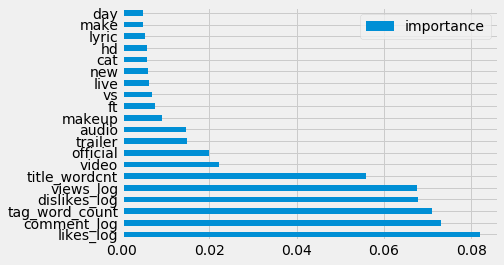

In [26]:
f.plot(kind="barh")

## Grid Search finding best parameters for random forest

In [35]:
from sklearn.model_selection import GridSearchCV


In [37]:
clf = RandomForestClassifier()

param_grid = {
    'criterion': ['entropy'],
    'max_depth': [1, 2, 5],
    'min_samples_split': [1, 5, 10]
}

gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(x_train, y_train)

gs_tree.best_params_

/Users/zoe/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/zoe/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/zoe/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a floa

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}

## Best parameter in classifying Random Forest 
##{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}

In [40]:
b = evaluate(y_test, rf_pred, "Random Forest")

# Adaptive Boosting Tree

In [41]:
from sklearn.ensemble import AdaBoostClassifier

In [42]:
start = time.time()
adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(x_train, y_train)
ab_runtime = time.time() - start
ab_pred = adaboost_clf.predict(x_test)
print_accuracy_indices(y_test, ab_pred)

Precision Score: 0.2605583246283081
Recall Score: 0.36131163587422
Accuracy Score: 0.36131163587422
F1 Score: 0.2337035225400212


/Users/zoe/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
pd.crosstab(y_test, ab_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,5,6,All
True,,,,
-1,4,5,0,9
0,600,1,23,624
1,2483,6,37,2526
2,861,3,20,884
3,821,5,3,829
4,488,0,9,497
5,544,29,2,575
6,812,6,441,1259
7,954,3,13,970


In [48]:
c = evaluate(y_test, ab_pred, 'Adapative Boosting Tree')

## Gradient Boosting

In [49]:
start = time.time()
gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(x_train, y_train)
gb_runtime = time.time() - start
gb_pred = gbt_clf.predict(x_test)
print_accuracy_indices(y_test, gb_pred)

Precision Score: 0.7571430652610677
Recall Score: 0.6476202128961214
Accuracy Score: 0.6476202128961214
F1 Score: 0.6350504258079539


In [50]:
d = evaluate(y_test, gb_pred, 'Gradient Boosting')


## SVM

In [139]:
svm_train, svm_test, svmy_train, svmy_test = train_test_split(x, y, test_size = 0.2)


In [140]:
start = time.time()
svm_clf = svm.NuSVC(kernel='rbf',nu=0.01)
svm_clf.fit(svm_train, svmy_train)
svm_runtime = time.time() - start
svm_runtime

101.72239780426025

In [96]:
#As a matter of fact, Looped from 1. to 0.1 (decreasing in decimal units) 
#and still got the error, then just tried with 0.01 and no complaints arose. 
#But of course, you should check the results of fitting your model with that value

In [143]:
svm_pred = svm_clf.predict(svm_test)
print_accuracy_indices(svmy_test, svm_pred)

Precision Score: 0.32215277989349744
Recall Score: 0.2494799951058363
Accuracy Score: 0.2494799951058363
F1 Score: 0.2496993358357868


In [144]:
e = evaluate(y_test, svm_pred, 'SVM')

## Decision Trees

In [145]:
start = time.time()
dt_classifier = DecisionTreeClassifier()  
dt_classifier.fit(x_train, y_train) 
dt_runtime = time.time() - start

In [146]:
dt_pred = dt_classifier.predict(x_test)  
print_accuracy_indices(y_test, dt_pred)

Precision Score: 0.8929571322485155
Recall Score: 0.892328398384926
Accuracy Score: 0.892328398384926
F1 Score: 0.892498289816673


In [147]:
f = evaluate(y_test, dt_pred, 'Decision Tree')

## Naive Bayes Classifer


Naive Bayes classifier – Naive Bayes classification method is based on Bayes’ theorem. It is termed as ‘Naive’ because it assumes independence between every pair of feature in the data. Let (x1, x2, …, xn) be a feature vector and y be the class label corresponding to this feature vector.

In [148]:
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
start = time.time()
gnb = GaussianNB().fit(x_train, y_train) 
gnb_predictions = gnb.predict(x_test) 
# accuracy on X_test 
accuracy = gnb.score(x_test, y_test) 
nb_runtime = time.time() - start

print (accuracy) 
# creating a confusion matrix 
nbcm = confusion_matrix(y_test, gnb_predictions)


0.3997308209959623


In [149]:
nbpred = gnb.predict(x_test)  
print_accuracy_indices(y_test, gnb_predictions)

Precision Score: 0.6322324645854984
Recall Score: 0.3997308209959623
Accuracy Score: 0.3997308209959623
F1 Score: 0.42163220349055036


In [53]:
g = evaluate(y_test, nbpred, 'Naive Bayes')


## Multinomial NB

In [54]:
from sklearn.naive_bayes import MultinomialNB

In [55]:
start = time.time()
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb_runtime = time.time() - start
mnb_runtime

0.1369330883026123

In [57]:
mnb_pred = mnb.predict(x_test)
print_accuracy_indices(y_test, mnb_pred)

Precision Score: 0.5140623422043068
Recall Score: 0.4098862106937477
Accuracy Score: 0.4098862106937477
F1 Score: 0.3797514010547937


/Users/zoe/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
h = evaluate(y_test, mnb_pred, 'Multinomial Naive Bayes')


## Bagging

In [150]:
start = time.time()
bt_classifier = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=100)
bt_classifier.fit(x_train, y_train)
bt_runtime = time.time() - start

In [153]:
bt_pred = bt_classifier.predict(x_test)
print_accuracy_indices(y_test, bt_pred)

Precision Score: 0.5418965048583988
Recall Score: 0.40633794200416
Accuracy Score: 0.40633794200416
F1 Score: 0.2923428977803924


/Users/zoe/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [154]:
i = evaluate(y_test, bt_pred, 'Bagged Trees')


## PCA

Text(0, 0.5, 'Cumulative explained variance')

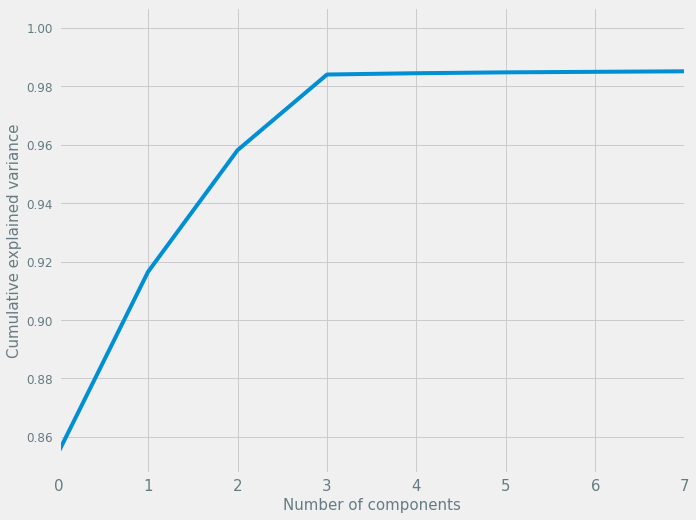

In [85]:
from sklearn.decomposition import PCA
plt.figure(figsize=(10, 8))
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,7,1)
plt.tick_params(labelsize=12)
plt.xticks(size=15)
plt.xlabel('Number of components', size =15)
plt.ylabel('Cumulative explained variance',size =15)

In [75]:
df2 = pd.read_csv('grouped.csv')

In [40]:
x_pca = pca.transform(x)
x_pca

array([[-2.81578519e+00, -1.02758819e+00,  6.17249686e-01, ...,
        -3.77803394e-03,  5.85309683e-03,  7.69643144e-03],
       [-3.84018876e+00, -7.58590721e-04,  5.07824017e-01, ...,
        -1.94875101e-02,  1.55695014e-02,  1.68063545e-02],
       [-3.89097294e+00,  4.13253974e-01, -2.84209488e-02, ...,
         3.87477452e-03, -2.70899421e-03,  5.19460835e-03],
       ...,
       [-1.62816477e+00, -2.22789927e-01, -3.24415503e-01, ...,
         1.82766642e-02,  2.87805497e-02, -3.26814067e-02],
       [-4.22777364e+00,  5.11965897e-02, -5.44101864e-01, ...,
         6.76564331e-02,  4.98465266e-04,  9.95142424e-03],
       [-8.18689890e+00,  2.67195217e-01,  2.27465283e+00, ...,
         9.61462424e-03,  1.88805441e-03, -2.32879181e-02]])

## Results Table 

In [155]:
results = pd.DataFrame()

In [156]:
results = results.append([a0, a, b, c, d, e, f, g, h, i])
results.columns = ['Model', 'Precision Score', 'Recall Score', 'Accuracy Score', 'F1 Score']
results['Model Runtime'] = [baseline_runtime, knn_runtime, rf_runtime, ab_runtime, gb_runtime, svm_runtime, dt_runtime, nb_runtime,
                            mnb_runtime, bt_runtime]
results

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Model Runtime
0,Baseline,0.095522,0.309066,0.309066,0.145939,0.002567
1,K Nearest Neighbors,0.838397,0.838003,0.838003,0.837820,0.813620
2,Random Forest,0.970892,0.970513,0.970513,0.970507,15.422421
3,Adapative Boosting Tree,0.260558,0.361312,0.361312,0.233704,5.167915
4,Gradient Boosting,0.757143,0.647620,0.647620,0.635050,143.387378
5,SVM,0.184921,0.119907,0.119907,0.124085,101.722398
6,Decision Tree,0.892957,0.892328,0.892328,0.892498,1.752545
7,Naive Bayes,0.632232,0.399731,0.399731,0.421632,0.631471
8,Multinomial Naive Bayes,0.514062,0.409886,0.409886,0.379751,0.136933
9,Bagged Trees,0.541897,0.406338,0.406338,0.292343,21.666396


In [68]:
probas = rfclassifier.predict_proba(x_test)

## Dealing with imbalanced 

In [53]:
from imblearn.over_sampling import SMOTE 


In [54]:
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(x_train, y_train)

In [55]:
smote = rfclassifier.fit(X_train, y_train)
smote_pred = smote.predict(x_test)

In [56]:
print_accuracy_indices(y_test, smote_pred)

Precision Score: 0.963663381265063
Recall Score: 0.963404672439144
Accuracy Score: 0.963404672439144
F1 Score: 0.9634673657649943


In [234]:
cm = skm.multilabel_confusion_matrix(y_test, rfy_pred)
print(cm)
print( skm.classification_report(y_test,rfy_pred))

[[[7490   39]
  [  45  587]]

 [[5562  198]
  [  65 2336]]

 [[7232   40]
  [  71  818]]

 [[7274   61]
  [  72  754]]

 [[7611   30]
  [  40  480]]

 [[7566    8]
  [  47  540]]

 [[6827   25]
  [  36 1273]]

 [[7130   34]
  [  59  938]]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       632
           1       0.92      0.97      0.95      2401
           2       0.95      0.92      0.94       889
           3       0.93      0.91      0.92       826
           4       0.94      0.92      0.93       520
           5       0.99      0.92      0.95       587
           6       0.98      0.97      0.98      1309
           7       0.97      0.94      0.95       997

    accuracy                           0.95      8161
   macro avg       0.95      0.94      0.94      8161
weighted avg       0.95      0.95      0.95      8161



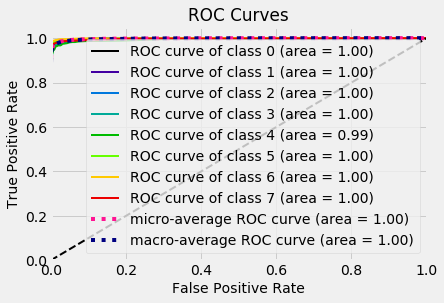

In [72]:
skplt.metrics.plot_roc(y_test, probas)

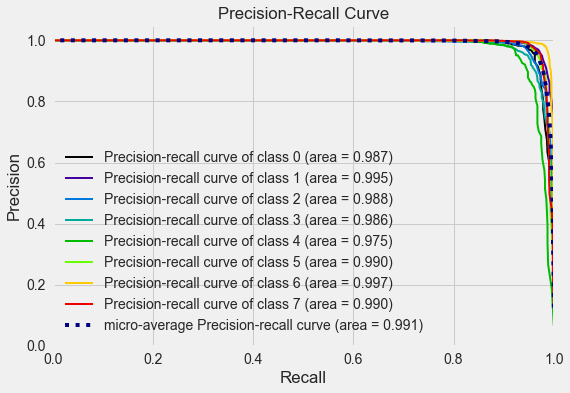

In [104]:
skplt.metrics.plot_precision_recall(y_test, probas, title='Precision-Recall Curve', plot_micro=True, classes_to_plot=None, ax=None, figsize=None, 
                                    cmap='nipy_spectral', title_fontsize='large', text_fontsize='medium')

In [113]:
plt.style.use('fivethirtyeight')

In [137]:
!pip install matplotlib.pyplot --upgrade

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


In [32]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /Users/zoe/anaconda3/lib/python3.7/site-packages (0.9.0)


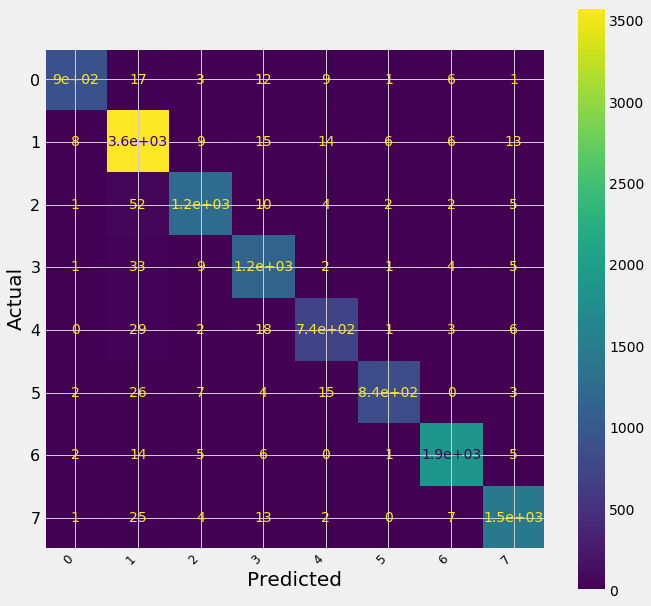

In [38]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(rfclassifier, x_test, y_test, ax=ax)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Actual", fontsize=20)
for label in ax.get_xticklabels():
    label.set_fontsize(12) 
    label.set_ha("right")
    label.set_rotation(45)

for label in ax.get_yticklabels():
    label.set_fontsize(16) 

In [41]:
df1 = pd.read_csv('grouped.csv')

Confusion matrix, without normalization
[[ 899   17    3   12    9    1    6    1]
 [   8 3583    9   15   14    6    6   13]
 [   1   52 1248   10    4    2    2    5]
 [   1   33    9 1151    2    1    4    5]
 [   0   29    2   18  735    1    3    6]
 [   2   26    7    4   15  841    0    3]
 [   2   14    5    6    0    1 1882    5]
 [   1   25    4   13    2    0    7 1451]]
Normalized confusion matrix
[[9.48312236e-01 1.79324895e-02 3.16455696e-03 1.26582278e-02
  9.49367089e-03 1.05485232e-03 6.32911392e-03 1.05485232e-03]
 [2.18938150e-03 9.80569239e-01 2.46305419e-03 4.10509031e-03
  3.83141762e-03 1.64203612e-03 1.64203612e-03 3.55774494e-03]
 [7.55287009e-04 3.92749245e-02 9.42598187e-01 7.55287009e-03
  3.02114804e-03 1.51057402e-03 1.51057402e-03 3.77643505e-03]
 [8.29187396e-04 2.73631841e-02 7.46268657e-03 9.54394693e-01
  1.65837479e-03 8.29187396e-04 3.31674959e-03 4.14593698e-03]
 [0.00000000e+00 3.65239295e-02 2.51889169e-03 2.26700252e-02
  9.25692695e-01 1.259445

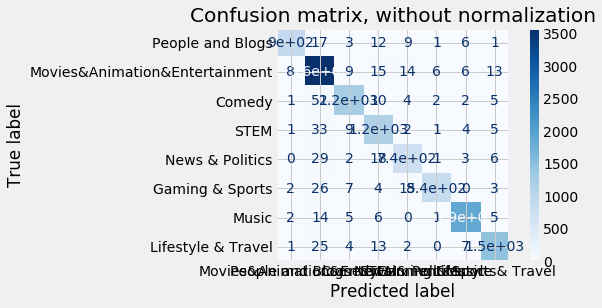

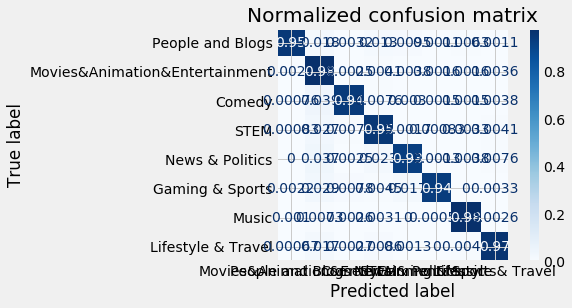

In [43]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix


class_names = df1['category_name'].unique()

# Split the data into a training set and a test set

#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rfclassifier, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)


In [ ]:
matplotlib.pyplot.imshow(y, cmap=)

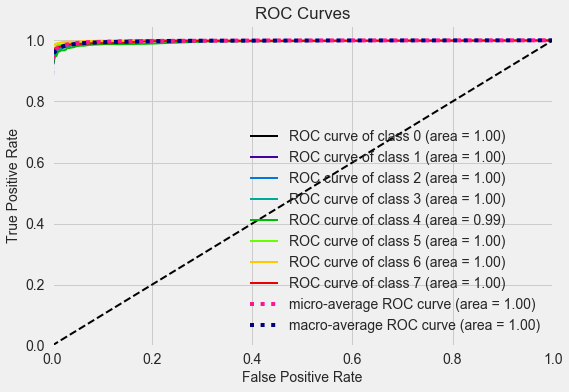

In [105]:
skplt.metrics.plot_roc(y_test, probas)